# Récupération et affichage d'images optiques.

Les images optiques sont créées par le capteur OCLI de Sentinel 3. Nous allons récupérer des images prétraitées par GLS sur l'ensemble du globe et extraire des zones géographiques qui nous intéressent.

_Version 1.0 [05/02/2023] Jérôme Lacaille_

In [1]:
import os
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import matplotlib.dates as mdt
from matplotlib.patches import Rectangle
%matplotlib inline

plt.rcParams["figure.figsize"] = (9,6)

On importe notre package et on s'assure qu'on peut le modifier de manière interactive.

In [2]:
import satellite as sat

In [3]:
%reload_ext autoreload
%autoreload 2

Juste pour s'assurer que tout va bien on charge une liste de zones. Vous pouvez regarder les zones que j'ai choisies, mais vous pouvez très bien,pour la suite utiliser des zones définies par vous-mêmes.

In [4]:
gz = sat.GeoZone('map.geojson')
zone = gz[2]
zone

{'name': 'Chypre',
 'bbox': [34.85709260445668,
  23.397028867484522,
  35.631415093017225,
  26.44578481885614]}

## 1. Compréhension du stockage des images.
Dans les lignes suivantes nous allons charger des images "netCDF" et afficher leurs valeurs sur les zones géographiques qui nous intéressent.

## 1.1 Détails des données disponibles.
Créons une table contenant pour chaque ligne la date de création "DATE", le chemin du fichier "FILE" et le numéro de révision par GLS "REVISION".

In [5]:
# On se souvient que le répertoire "EARTHDIR" contient les données de la terre.
# Or nous avons stocké les images dans un sous répertoire FCOVER d ece chemin.
sat.EARTHDIR

'/Users/holie/wrk0/satellite/data/zones/_Earth/'

In [6]:
rawdir = ...
rawdir

'/Users/holie/wrk0/satellite/data/zones/_Earth/FCOVER/'

Récupérons la liste des fichiers .nc.
J'utilise usuellement le module "os", mais vous pouvez aussi installer "pathlib".

> [Documentation du module os](https://docs.python.org/fr/3/library/os.html)

In [22]:
# Gestion des fichiers et dossiers.
import os

In [23]:
# Les dossiers téléchargés.
os.listdir(rawdir)

['.DS_Store',
 'FCOVER300_RT6_202106200000_GLOBE_OLCI_V1.1.2',
 'FCOVER300_RT6_202102200000_GLOBE_OLCI_V1.1.1']

Parcourrez l'ensemble de ces dossiers pour ne lister que les fichiers netCDF.

_Astuce : utilisez `os.walk` et `os.endwith`._

In [26]:
# Les fichiers .nc
...
listfiles

['c_gls_FCOVER300-RT6_202106200000_GLOBE_OLCI_V1.1.2.nc',
 'c_gls_FCOVER300-RT6_202102200000_GLOBE_OLCI_V1.1.1.nc']

Récupérez le dernier fichier.

_Astuce : utilisez "`_`"._

In [27]:
# Petite astuce : _ correspond aux dernier résultat affiché.
filename = _[-1]
filename

'c_gls_FCOVER300-RT6_202102200000_GLOBE_OLCI_V1.1.1.nc'

Maintenant on extrait la révision et la date à l'aide d'une experssion régulière.

> [Documentation sur les experssions régulières](https://docs.python.org/fr/3/library/re.html)

In [29]:
# Gestion des expressions régulières.
import re

In [30]:
# Pour extraire la révision et la date on recherche un pattern RT0_YYYYMMDD0*_ avec un chiffre à la place du 0.
print("Le nom du fichier :", filename)
m = re.search('(RT[0-9])_([0-9]+)_',filename)

print("Nombre de groupes :", m.lastindex)
print("La chaine entière :", m[0])
print("Le premier groupe :", m[1])
print("Le second groupe  :", m[2])
print("Tous les groupes  :", m.groups())

Le nom du fichier : c_gls_FCOVER300-RT6_202102200000_GLOBE_OLCI_V1.1.1.nc
Nombre de groupes : 2
La chaine entière : RT6_202102200000_
Le premier groupe : RT6
Le second groupe  : 202102200000
Tous les groupes  : ('RT6', '202102200000')


On veut le numéro de révision et une date Python.
Pour la date je vous conseille `pd.to_datetime(chaine,format)` car on va créer une table pandas et que cette fonction admet des paramètres de format.

In [33]:
from datetime import datetime

In [45]:
revision = int(m[1][2])
date = datetime.strptime(m[2],'%Y%m%d%H%M')
date2 = pd.to_datetime(m[2],format='%Y%m%d%H%M')
revision,date, date2

(6, datetime.datetime(2021, 2, 20, 0, 0), Timestamp('2021-02-20 00:00:00'))

Créer la table en parcourant la liste des fichiers.

* Attention, si deux fichiers sont datés du même jour, nous ne devons garder que celui qui a la révision la plus élevée.
* Ne pas oublier de mettre le chemin complet en rajoutant le répertoire contenant le fichier.

In [67]:
# Liste des fichiers disponibles.
...

df = pd.DataFrame({'DATE': D, 'FILE' : N, 'REVISION' : RT}) 
df

,DATE,FILE,REVISION
0,2021-06-20,/Users/holie/wrk0/satellite/data/zones/_Earth/...,6
1,2021-02-20,/Users/holie/wrk0/satellite/data/zones/_Earth/...,6


Mettre la date en index et triez la table par date croissante.

In [68]:
...
df

,FILE,REVISION
DATE,,
2021-02-20,/Users/holie/wrk0/satellite/data/zones/_Earth/...,6
2021-06-20,/Users/holie/wrk0/satellite/data/zones/_Earth/...,6


## 1.2 Analyse du contenu d'un fichier.
Les fichiers récupérés par GLS sont un peu différents des tables habituelles en analyse de données. On va en explorer le contenu, récupérer des informations sur une zone géographique et faire quelques calculs.

Récupérons le premier fichier.

In [134]:
img = 0
fname = df.FILE[img]
fname

'/Users/holie/wrk0/satellite/data/zones/_Earth/FCOVER/FCOVER300_RT6_202102200000_GLOBE_OLCI_V1.1.1/c_gls_FCOVER300-RT6_202102200000_GLOBE_OLCI_V1.1.1.nc'

Les fichiers ".nc" sont des fichiers netCDF qui nécessitent un package spécial pour les charger (netcdf4). Nous aurrons besoins de deux objets de ce composant : le Dataset qui contient l'image et la fonction num2date qui convertit les champs dates stockés en numériques sous netCDF en dates python.

> [netCDF (Network Comon Data Form)](https://fr.wikipedia.org/wiki/NetCDF)

> [Documentation de netcdf4](https://unidata.github.io/netcdf4-python/#variables-in-a-netcdf-file)

In [70]:
# Imports spécifique à la gestion des images.
from netCDF4 import Dataset, num2date # pylint: disable=no-name-in-module

On affiche quelques éléments de compréhension...

_Attention, ici on va garfder la ressource `nc` ouverte pour se faciliter l'étude, mais en général on essayera plutôt d'encadrer la ressource d'un groupe `with` ou d'une reprise sur erreur._

In [ ]:
nc = Dataset(fname, 'r')

In [122]:
print("Dimensions:\n", nc.dimensions)
print("Variables:\n", nc.variables.keys())
print("FCOVER dimensions:", nc.variables['FCOVER'].dimensions)
print("lat dimension:",nc.variables['lat'].dimensions)
fcover = nc.variables['FCOVER'][0,0:3,0:3]
fcover

Dimensions:
 {'lon': <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 120960, 'lat': <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 47040, 'time': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 1}
Variables:
 dict_keys(['FCOVER', 'LENGTH_AFTER', 'LENGTH_BEFORE', 'NOBS', 'QFLAG', 'RMSE', 'crs', 'lat', 'lon', 'time'])
FCOVER dimensions: ('time', 'lat', 'lon')
lat dimension: ('lat',)


masked_array(
  data=[[--, --, --],
        [--, --, --],
        [--, --, --]],
  mask=[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],
  fill_value=255,
  dtype=float64)

In [79]:
nc.variables['FCOVER'].dimensions

('time', 'lat', 'lon')

In [80]:
nc.variables['time'].dimensions

('time',)

L'ordre des variables dans la dimension correspond à celui d'une image, donc la première dimension et Y et pas X.

In [117]:
(nc.variables['time'].axis, ... , ...)

('T', 'Y', 'X')

Une chance ! Les unités correspondent bien à ce dont on a l'habitude.

In [89]:
(nc.variables['time'].units, ... , ...)

('days since 1970-01-01 00:00:00', 'degrees_east', 'degrees_north')

Affichez le détail de la variable FCOVER.

In [92]:
nc.variables['FCOVER']

<class 'netCDF4._netCDF4.Variable'>
uint8 FCOVER(time, lat, lon)
    _FillValue: 255
    standard_name: vegetation_area_fraction
    long_name: Fraction of green Vegetation Cover 333m
    grid_mapping: crs
    scale_factor: 0.004
    add_offset: 0.0
    units: 
    valid_range: [  0 250]
    missing_value: 255
unlimited dimensions: time
current shape = (1, 47040, 120960)
filling on

Maintenant on va extraire la partie de l'image correspondant à notre zone.

In [90]:
lat0,lon0,lat1,lon1 = zone['bbox']

In [123]:
# Les latitudes et longitudes sont jamais masquées, on peu récupérer les valeurs directement. Comme ce sont des dimensions, elles sont scalaires.
lon = nc.variables['lon'][:].data
lat = ...

En utilisant un "et" logique `np.logical_and` récupérez le contenu de notre zone d'intérêt.

In [129]:
bx = ...
by = ...
fc = nc.variables['FCOVER'][0, ..., ...]
fc

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=255)

Remplacez les valeurs masquées par des `np.nan` et affichez l'image avec `plt.imshow()`.

<mark>N'oubliez pas de fermer la ressource.</mark>

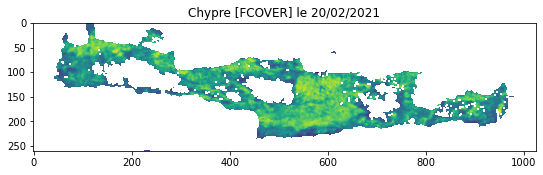

In [136]:
...

In [ ]:
# Fermeture de la ressource.
nc.close()